In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

clight = 299792.458

#MG RECONSTRUCTION PARAMETERS
MGbins = 20
sfac   = 10
zmin   = 0
zmax   = 5

GRreturn = False #If set to True the last bin for mu and eta is set to 1
                #If set to False the last bin is set to the value of the previous bin


import camb

cosmopars = {"omch2":0.12055785610846023,
             "ombh2":0.022445,
             "w":-1.0,
             "wa":0.0,
             "H0":67.,
             "ns":0.96,
             "As":2.12605e-9,
             "mnu":0.06,
             "tau":0.058,
             "num_massive_neutrinos": 1,
             "nnu": 3.046}

Omegam = (cosmopars['omch2']+cosmopars['ombh2'])/(cosmopars['H0']/100)**2


pars= camb.set_params(**cosmopars)

#Computing observables
zsamp    = np.linspace(0,5,10000)
results  = camb.get_background(pars)
hubble   = interp1d(zsamp,results.hubble_parameter(zsamp),kind='cubic')

In [2]:
#Getting real functions
E_11 = 0.5
E_22 = 0.1
mu_real  = interp1d(zsamp,1+E_11*(1-Omegam)*(cosmopars['H0']/hubble(zsamp))**2,kind='cubic')
eta_real = interp1d(zsamp,1+E_22*(1-Omegam)*(cosmopars['H0']/hubble(zsamp))**2,kind='cubic')

#Real function derivatives
mean_z = []
dermu_tab = []
dereta_tab = []
for ind in range(len(zsamp)-1):
    mean_z.append(0.5*(zsamp[ind+1]+zsamp[ind]))
    dermu_tab.append((mu_real(zsamp[ind+1])-mu_real(zsamp[ind]))/(zsamp[ind+1]-zsamp[ind]))
    dereta_tab.append((eta_real(zsamp[ind+1])-eta_real(zsamp[ind]))/(zsamp[ind+1]-zsamp[ind]))


der_mu_real = interp1d(mean_z,dermu_tab,kind='cubic')
der_eta_real = interp1d(mean_z,dereta_tab,kind='cubic')

tauder_mu_real = interp1d(mean_z,[-hubble(zi)/clight*dermu_tab[ind] for ind,zi in enumerate(mean_z)],
                          kind='cubic')
tauder_eta_real = interp1d(mean_z,[-hubble(zi)/clight*dereta_tab[ind] for ind,zi in enumerate(mean_z)],
                          kind='cubic')

#Binned function
z_lim  = np.linspace(zmin,zmax,MGbins)
z_b = []
for ind in range(len(z_lim)-1):
    z_b.append(0.5*(z_lim[ind+1]+z_lim[ind]))
    
mu_b  = mu_real(z_b)
eta_b = eta_real(z_b)
print('')
print('---------------ENTRIES FOR MGCAMB RECONSTRUCTION---------------')
print('MGbins = {}'.format(MGbins))
print('s_fac  = {}'.format(sfac))
print('z_b    =',*z_lim, sep=" ")
if GRreturn:
    mu_b_MGCAMB  = np.append(mu_b, 1)
    eta_b = np.append(eta_b, 1)
else:
    mu_b_MGCAMB  = np.append(mu_b, mu_b[-1])
    eta_b_MGCAMB = np.append(eta_b, eta_b[-1])
print('mu_b   =',*mu_b_MGCAMB, sep=" ")
print('eta_b  =',*eta_b_MGCAMB, sep=" ")
print('---------------------------------------------------------------')

mu  = np.zeros((len(zsamp)))
eta = np.zeros((len(zsamp)))
for ind,z in enumerate(zsamp):
    if z<z_lim[0]:
        mu[ind]  = mu_b[0]
        eta[ind] = eta_b[0]
    elif z>z_lim[-1]:
        mu[ind]  = mu_b[-1]
        eta[ind] = eta_b[-1]
    else:
        mu[ind]  =  mu_b[0]
        eta[ind]  =  eta_b[0]
        for ind2 in range(len(z_lim)-2):
            mu[ind] += (0.5*(mu_b[ind2+1]-mu_b[ind2])*
                           (1+np.tanh(sfac*(z-z_lim[ind2+1])/(z_lim[ind2+1]-z_lim[ind2]))))
            eta[ind] += (0.5*(eta_b[ind2+1]-eta_b[ind2])*
                           (1+np.tanh(sfac*(z-z_lim[ind2+1])/(z_lim[ind2+1]-z_lim[ind2]))))
            
            
#Binned derivative


der_z_lim = z_b
der_z_b   = []
for ind in range(len(der_z_lim)-1):
    der_z_b.append(0.5*(der_z_lim[ind+1]+der_z_lim[ind]))
der_mu_b  = [(mu_b[ind+1]-mu_b[ind])/(z_lim[ind+1]-z_lim[ind]) for ind in range(len(z_b)-1)]
der_eta_b = [(eta_b[ind+1]-eta_b[ind])/(z_lim[ind+1]-z_lim[ind]) for ind in range(len(z_b)-1)]

dermu  = np.zeros((len(zsamp)))
dereta = np.zeros((len(zsamp)))
for ind,z in enumerate(zsamp):
    if z<der_z_lim[0]:
        dermu[ind]  = der_mu_b[0]
        dereta[ind] = der_eta_b[0]
    elif z>der_z_lim[-1]:
        dermu[ind]  = der_mu_b[-1]
        dereta[ind] = der_eta_b[-1]
    else:
        dermu[ind]  =  der_mu_b[0]
        dereta[ind]  =  der_eta_b[0]
        for ind2 in range(len(der_z_lim)-2):
            dermu[ind] += (0.5*(der_mu_b[ind2+1]-der_mu_b[ind2])*
                           (1+np.tanh(sfac*(z-der_z_lim[ind2+1])/(der_z_lim[ind2+1]-der_z_lim[ind2]))))
            dereta[ind] += (0.5*(der_eta_b[ind2+1]-der_eta_b[ind2])*
                           (1+np.tanh(sfac*(z-der_z_lim[ind2+1])/(der_z_lim[ind2+1]-der_z_lim[ind2]))))  
            
taudermu = [-hubble(zi)/clight * dermu[ind] for ind,zi in enumerate(zsamp)]
taudereta = [-hubble(zi)/clight * dereta[ind] for ind,zi in enumerate(zsamp)]


---------------ENTRIES FOR MGCAMB RECONSTRUCTION---------------
MGbins = 20
s_fac  = 10
z_b    = 0.0 0.2631578947368421 0.5263157894736842 0.7894736842105263 1.0526315789473684 1.3157894736842104 1.5789473684210527 1.8421052631578947 2.1052631578947367 2.3684210526315788 2.631578947368421 2.894736842105263 3.1578947368421053 3.4210526315789473 3.6842105263157894 3.9473684210526314 4.2105263157894735 4.473684210526316 4.7368421052631575 5.0
mu_b   = 1.297904685787941 1.2200401432968724 1.1593080364369706 1.1155108064929307 1.0848344688103075 1.0634057311469338 1.0482823879999976 1.0374381120600569 1.0295227138293717 1.0236412577917804 1.0191960971203056 1.0157827620410114 1.0131231760462882 1.0110229942853357 1.0093441716331457 1.007987115701829 1.0068789111508023 1.0059654328228929 1.0052059835881102 1.0052059835881102
eta_b  = 1.0595809371575882 1.0440080286593745 1.031861607287394 1.023102161298586 1.0169668937620615 1.0126811462293868 1.0096564775999994 1.0074876224120113 1.0059045

In [3]:
#LOAD MGCAMB RESULTS

MGfuncs= pd.read_csv("./MGCAMB/recon_MGCAMB_debug_MG_fncs.dat",delimiter="   ",header=None, skiprows=1, 
                     names=['k','a','mu','gamma','mudot','gammadot','Q','R','Phi','Psi','dPhi','dPsi'])
singlek = MGfuncs[(MGfuncs.k == MGfuncs['k'].iloc[0])]



MGz_recon   = -1+1/singlek['a'].values[:]
MGmu_recon  = singlek['mu'].values[:]
MGeta_recon = singlek['gamma'].values[:]
MGdermu_recon  = singlek['mudot'].values[:]
MGdereta_recon = singlek['gammadot'].values[:]
MGPhi_recon = singlek['Phi'].values[:]
MGPsi_recon = singlek['Psi'].values[:]
MGderPhi_recon = singlek['dPhi'].values[:]
MGderPsi_recon = singlek['dPsi'].values[:]


MGfuncs= pd.read_csv("./MGCAMB/pkpar_MGCAMB_debug_MG_fncs.dat",delimiter="   ",header=None, skiprows=1, 
                     names=['k','a','mu','gamma','mudot','gammadot','Q','R','Phi','Psi','dPhi','dPsi'])
singlek = MGfuncs[(MGfuncs.k == MGfuncs['k'].iloc[0])]

MGpk = 0. #Here read pk


MGz_real   = -1+1/singlek['a'].values[:]
MGmu_real  = singlek['mu'].values[:]
MGeta_real = singlek['gamma'].values[:]
MGdermu_real  = singlek['mudot'].values[:]
MGdereta_real = singlek['gammadot'].values[:]
MGPhi_real = singlek['Phi'].values[:]
MGPsi_real = singlek['Psi'].values[:]
MGderPhi_real = singlek['dPhi'].values[:]
MGderPsi_real = singlek['dPsi'].values[:]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


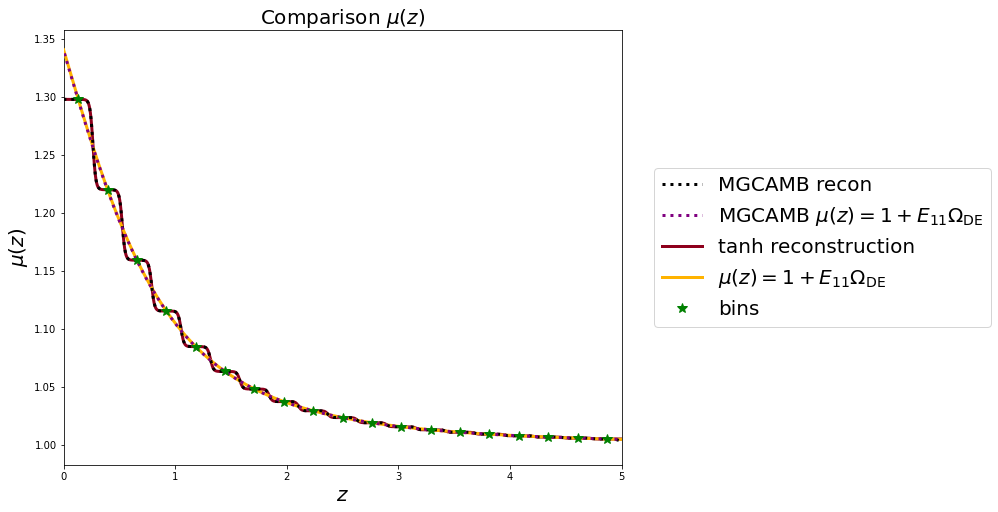

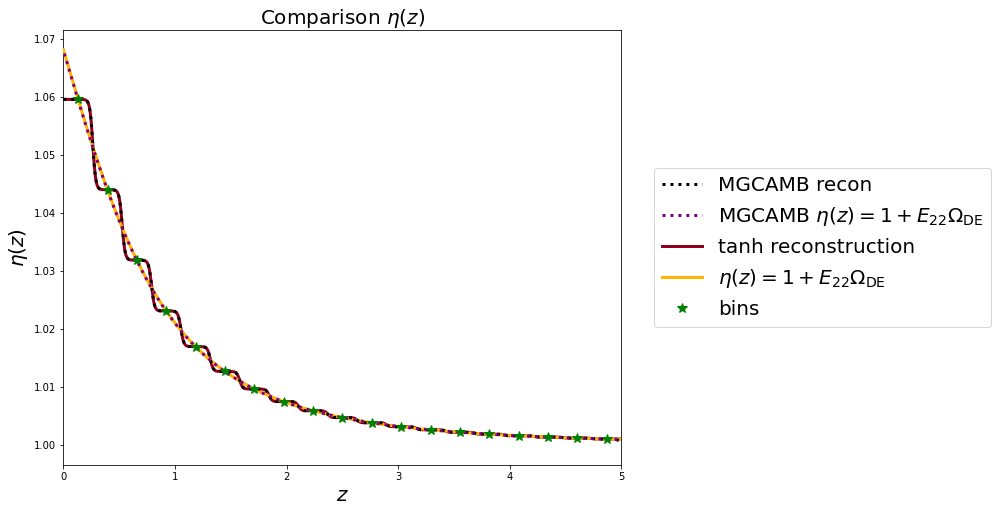

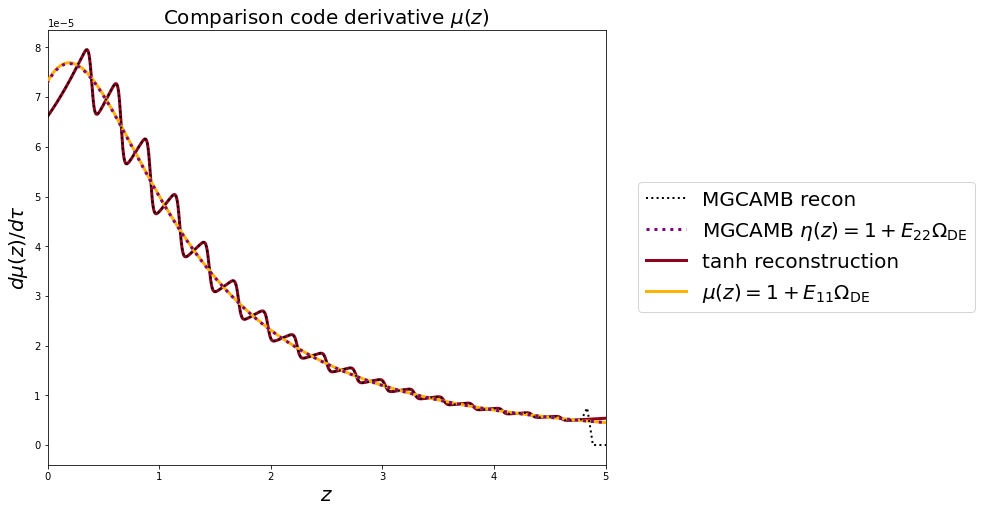

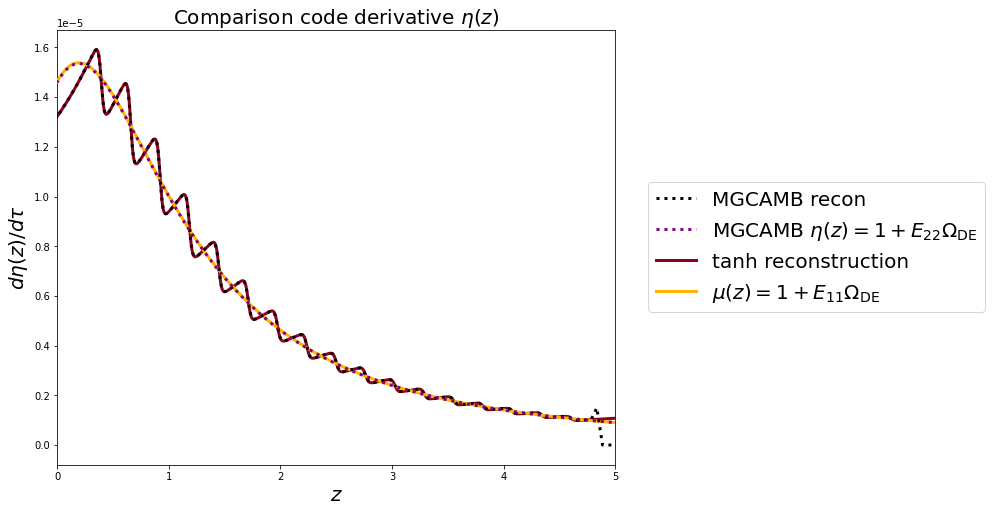

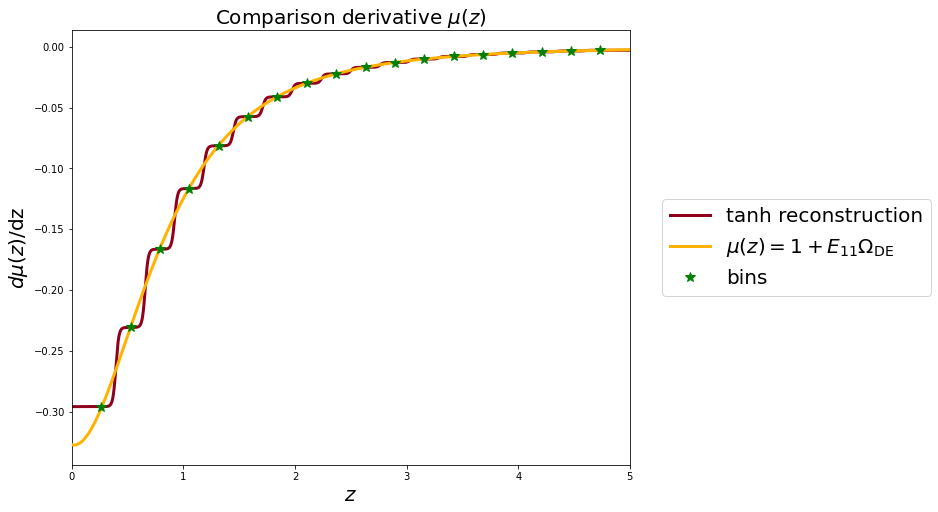

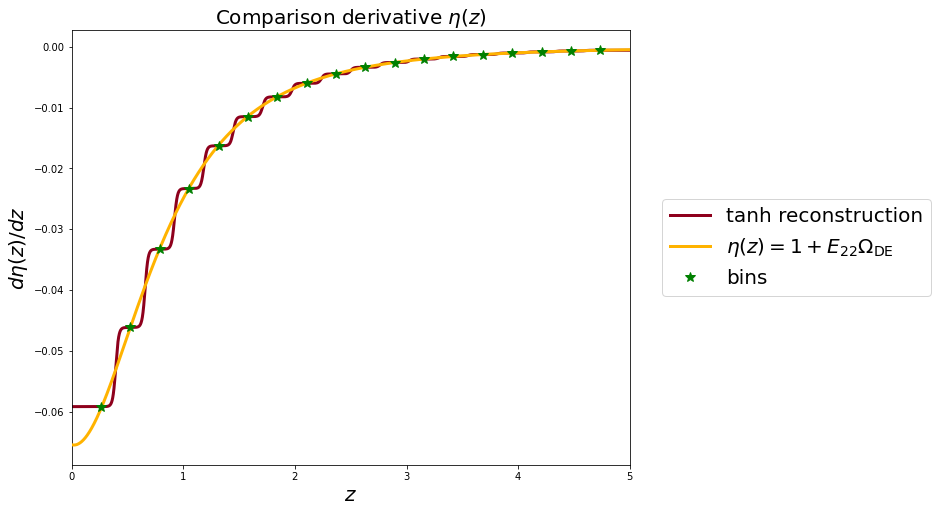

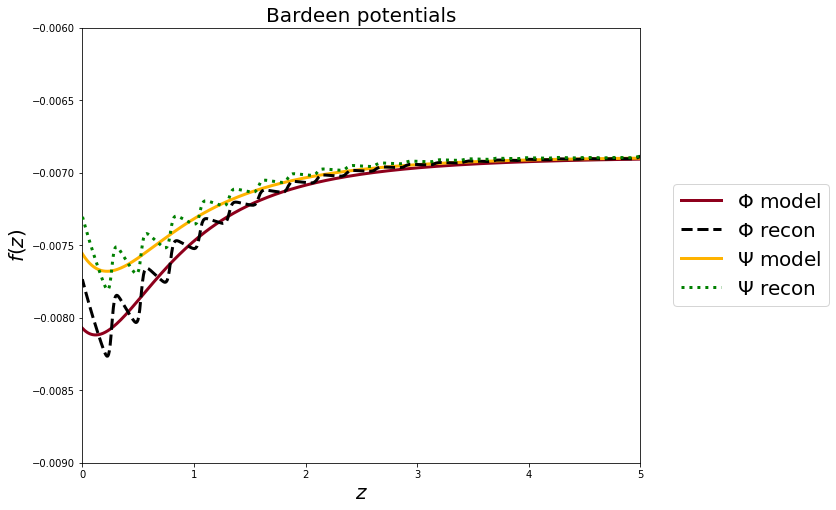

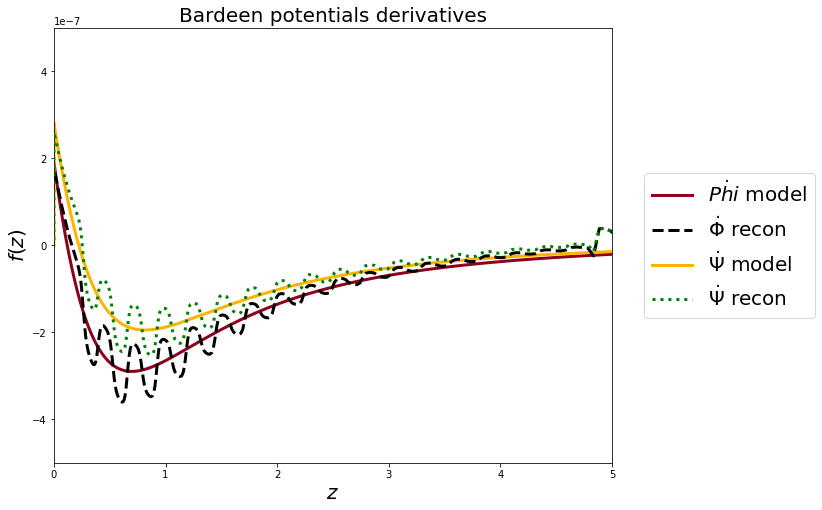

In [4]:
#Check mu eta functions


plt.figure(figsize=(10, 8))
plt.title(r'Comparison $\mu(z)$',fontsize=20)
plt.plot(MGz_recon,MGmu_recon,label=r'MGCAMB recon',color='black',lw=3,ls=':',zorder=10)
plt.plot(MGz_real,MGmu_real,label=r'MGCAMB $\mu(z)=1+E_{11}\Omega_{\rm DE}$',color='purple',lw=3,ls=':',zorder=10)
plt.plot(zsamp,mu,label=r'tanh reconstruction',color='#8E001C',lw=3,zorder=1)
plt.plot(zsamp,mu_real(zsamp),label=r'$\mu(z)=1+E_{11}\Omega_{\rm DE}$',color='#FFB300',lw=3,ls='-',zorder=5)
plt.errorbar(z_b,mu_b,label=r'bins',color='green',ls='',marker='*',markersize=10,zorder=20)
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$\mu(z)$',fontsize=20)
plt.xlim([0,z_lim[-1]])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)

plt.figure(figsize=(10, 8))
plt.title(r'Comparison $\eta(z)$',fontsize=20)
plt.plot(MGz_recon,MGeta_recon,label=r'MGCAMB recon',color='black',lw=3,ls=':',zorder=10)
plt.plot(MGz_real,MGeta_real,label=r'MGCAMB $\eta(z)=1+E_{22}\Omega_{\rm DE}$',color='purple',lw=3,ls=':',zorder=10)
plt.plot(zsamp,eta,label=r'tanh reconstruction',color='#8E001C',lw=3,zorder=1)
plt.plot(zsamp,eta_real(zsamp),label=r'$\eta(z)=1+E_{22}\Omega_{\rm DE}$',color='#FFB300',lw=3,ls='-',zorder=5)
plt.errorbar(z_b,eta_b,label=r'bins',color='green',ls='',marker='*',markersize=10,zorder=20)
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$\eta(z)$',fontsize=20)
plt.xlim([0,z_lim[-1]])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)


plt.figure(figsize=(10, 8))
plt.title(r'Comparison code derivative $\mu(z)$',fontsize=20)
plt.plot(MGz_recon,MGdermu_recon,label=r'MGCAMB recon',color='black',lw=2,ls=':',zorder=10)
plt.plot(MGz_real,MGdermu_real,label=r'MGCAMB $\eta(z)=1+E_{22}\Omega_{\rm DE}$',
         color='purple',lw=3,ls=':',zorder=10)
plt.plot(zsamp,taudermu,label=r'tanh reconstruction',color='#8E001C',lw=3,zorder=1)
plt.plot(mean_z,tauder_mu_real(mean_z),label=r'$\mu(z)=1+E_{11}\Omega_{\rm DE}$',color='#FFB300',
         lw=3,ls='-',zorder=5)
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$d\mu(z)/d\tau$',fontsize=20)
plt.xlim([0,z_lim[-1]])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)

plt.figure(figsize=(10, 8))
plt.title(r'Comparison code derivative $\eta(z)$',fontsize=20)
plt.plot(MGz_recon,MGdereta_recon,label=r'MGCAMB recon',color='black',lw=3,ls=':',zorder=10)
plt.plot(MGz_real,MGdereta_real,label=r'MGCAMB $\eta(z)=1+E_{22}\Omega_{\rm DE}$',
         color='purple',lw=3,ls=':',zorder=10)
plt.plot(zsamp,taudereta,label=r'tanh reconstruction',color='#8E001C',lw=3,zorder=1)
plt.plot(mean_z,tauder_eta_real(mean_z),label=r'$\mu(z)=1+E_{11}\Omega_{\rm DE}$',color='#FFB300',
         lw=3,ls='-',zorder=5)
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$d\eta(z)/d\tau$',fontsize=20)
plt.xlim([0,z_lim[-1]])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)

plt.figure(figsize=(10, 8))
plt.title(r'Comparison derivative $\mu(z)$',fontsize=20)
plt.plot(zsamp,dermu,label=r'tanh reconstruction',color='#8E001C',lw=3,zorder=1)
plt.plot(mean_z,der_mu_real(mean_z),label=r'$\mu(z)=1+E_{11}\Omega_{\rm DE}$',color='#FFB300',lw=3,ls='-',zorder=5)
plt.errorbar(der_z_b,der_mu_b,label=r'bins',color='green',ls='',marker='*',markersize=10,zorder=20)
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$d\mu(z)$/dz',fontsize=20)
plt.xlim([0,z_lim[-1]])
#plt.ylim([-2,2])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)

plt.figure(figsize=(10, 8))
plt.title(r'Comparison derivative $\eta(z)$',fontsize=20)
plt.plot(zsamp,dereta,label=r'tanh reconstruction',color='#8E001C',lw=3,zorder=1)
plt.plot(mean_z,der_eta_real(mean_z),label=r'$\eta(z)=1+E_{22}\Omega_{\rm DE}$',color='#FFB300',lw=3,ls='-',zorder=5)
plt.errorbar(der_z_b,der_eta_b,label=r'bins',color='green',ls='',marker='*',markersize=10,zorder=20)
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$d\eta(z)/dz$',fontsize=20)
plt.xlim([0,z_lim[-1]])
#plt.ylim([-2,2])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)


plt.figure(figsize=(10, 8))
plt.title(r'Bardeen potentials',fontsize=20)
plt.plot(MGz_real,MGPhi_real,color='#8E001C',lw=3,ls='-',zorder=0,label=r'$\Phi$ model')
plt.plot(MGz_recon,MGPhi_recon,color='black',lw=3,ls='--',zorder=10,label=r'$\Phi$ recon')
plt.plot(MGz_real,MGPsi_real,color='#FFB300',lw=3,ls='-',zorder=0,label=r'$\Psi$ model')
plt.plot(MGz_recon,MGPsi_recon,color='green',lw=3,ls=':',zorder=10,label=r'$\Psi$ recon')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$f(z)$',fontsize=20)
plt.xlim([0,z_lim[-1]])
plt.ylim([-0.009,-0.006])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)

plt.figure(figsize=(10, 8))
plt.title(r'Bardeen potentials derivatives',fontsize=20)
plt.plot(MGz_real,MGderPhi_real,color='#8E001C',lw=3,ls='-',zorder=0,label=r'$\dot{Phi}$ model')
plt.plot(MGz_recon,MGderPhi_recon,color='black',lw=3,ls='--',zorder=10,label=r'$\dot{\Phi}$ recon')
plt.plot(MGz_real,MGderPsi_real,color='#FFB300',lw=3,ls='-',zorder=0,label=r'$\dot{\Psi}$ model')
plt.plot(MGz_recon,MGderPsi_recon,color='green',lw=3,ls=':',zorder=10,label=r'$\dot{\Psi}$ recon')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$f(z)$',fontsize=20)
plt.xlim([0,z_lim[-1]])
plt.ylim([-0.5e-6,0.5e-6])
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)

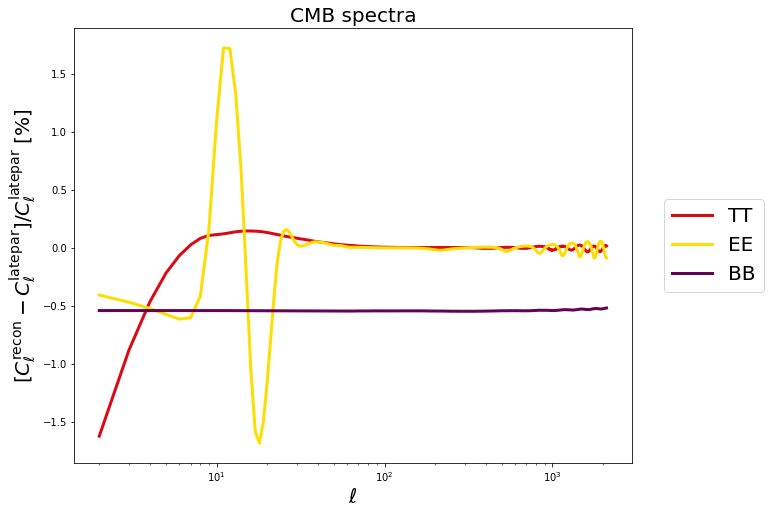

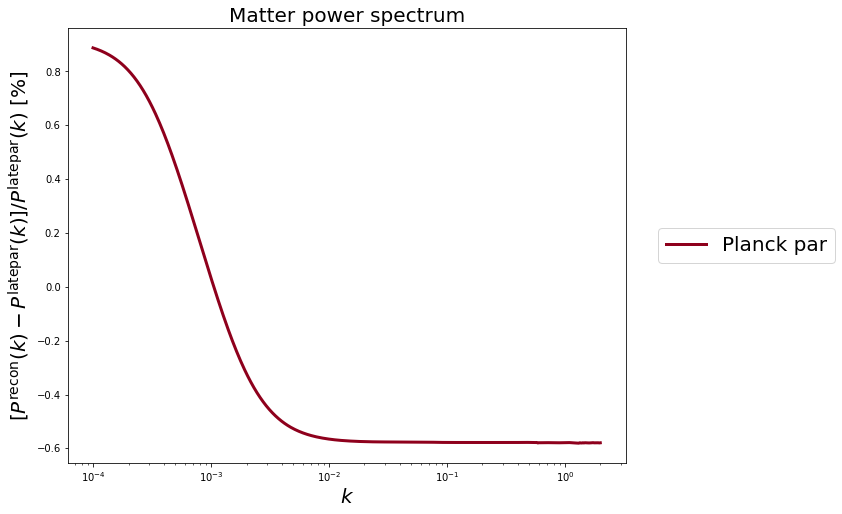

In [5]:
recon_CMB = np.loadtxt('./MGCAMB/recon_lensedCls.dat')
recon_Pk  = np.loadtxt('./MGCAMB/recon_matterpower.dat')


pkpar_CMB = np.loadtxt('./MGCAMB/pkpar_lensedCls.dat')
pkpar_Pk  = np.loadtxt('./MGCAMB/pkpar_matterpower.dat')


plt.figure(figsize=(10, 8))
plt.title('CMB spectra',fontsize=20)
plt.plot(pkpar_CMB[:,0],100*(recon_CMB[:,1]-pkpar_CMB[:,1])/pkpar_CMB[:,1],color='#DA0914',
         ls='-',zorder=0,label=r'TT',lw=3)
plt.plot(pkpar_CMB[:,0],100*(recon_CMB[:,2]-pkpar_CMB[:,2])/pkpar_CMB[:,2],color='#FCDE03',
         ls='-',zorder=0,label=r'EE',lw=3)
plt.plot(pkpar_CMB[:,0],100*(recon_CMB[:,3]-pkpar_CMB[:,3])/pkpar_CMB[:,3],color='#630356',
         ls='-',zorder=0,label=r'BB',lw=3)
plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$[C_\ell^{\rm recon}-C_\ell^{\rm latepar}]/C_\ell^{\rm latepar}$ [%]',fontsize=20)
#plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)



plt.figure(figsize=(10, 8))
plt.title('Matter power spectrum',fontsize=20)
plt.plot(pkpar_Pk[:,0],100*(recon_Pk[:,1]-pkpar_Pk[:,1])/pkpar_Pk[:,1],color='#8E001C',ls='-',
         zorder=0,label=r'Planck par',lw=3)
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel(r'$[P^{\rm recon}(k)-P^{\rm latepar}(k)]/P^{\rm latepar}(k)$ [%]',fontsize=20)
#plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left",fontsize=20)